In [1]:
using ComputationalHeatTransfer
using LaTeXStrings
using Revise
using LinearAlgebra
using DifferentialEquations
using Interpolations
using JLD2
using Plots
pyplot()  

cd(dirname(pwd()))
cd("src") 
includet("OneDOHP.jl")
using ..OneDOHP

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise C:\Users\liyux\.julia\packages\Revise\1boD5\src\packagedef.jl:1369


## turned on boiling

# the plate code initialization

### Physical parameters

In [2]:
ρ = 2700;
c = 8.97e02;
k = 1.67e02;
d = 2e-3;
params = HeatConductionParameters(ρ,c,k,thickness=d)

HeatConductionParameters(2700.0, 897.0, 167.0, 6.895412692514142e-5, 0.002)

### Geometry parameters

In [3]:
inch = 2.54e-2;
Lx = 0.1524;
Ly = 0.0648;

In [4]:
xlim = (-Lx/2,Lx/2) .*1.0
ylim = (-Ly/2,Ly/2) .*1.0
Δx, Δt = setstepsizes(params.α,gridPe=8.0,fourier=0.3)


(0.0005516330154011314, 0.001323919236962715)

### Set up the evaporator and condenser

In [5]:
eb1 = Rectangle(0.5inch,1.0inch,1.5*Δx)
Te = RigidTransform((0.7inch,-0.0),0.0)
Te(eb1)

eb2 = Rectangle(0.5inch,1.0inch,1.5*Δx)
Te = RigidTransform((-0.7inch,-0.0),0.0)
Te(eb2)

cb1 = Rectangle(0.5inch*0.9,Ly*0.9/2,1.5*Δx)
Tc = RigidTransform((-2.5inch,-0.0),0.0)
Tc(cb1)

cb2 = Rectangle(0.5inch*0.9,Ly*0.9/2,1.5*Δx)
Tc = RigidTransform((2.5inch,-0.0),0.0)
Tc(cb2)

qe = 15500.0
hc = 1500.0
Tc = 0.0

eparams1 = PrescribedHeatFluxRegion(qe,eb1);
eparams2 = PrescribedHeatFluxRegion(qe,eb2);
cparams1 = PrescribedHeatModelRegion(hc,Tc,cb1);
cparams2 = PrescribedHeatModelRegion(hc,Tc,cb2);

### Set up the OHP

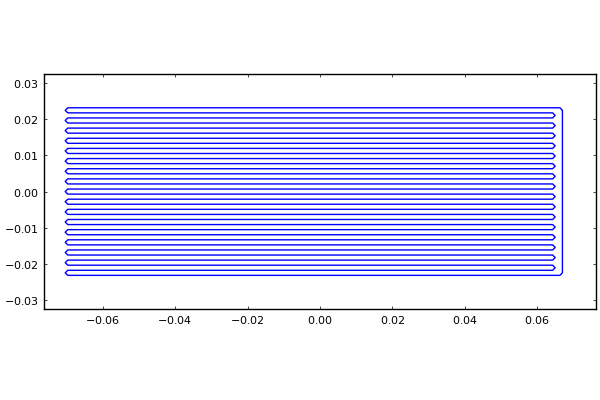

In [6]:
ds = 1.5Δx
nturn = 16
#pitch = 0.125
length_ohp = 46.25*1e-3
height = 133.83*1e-3
gap = d
pitch = length_ohp/(2*nturn+1)
x0, y0 = height/2, length_ohp/2
x, y, xf, yf = ComputationalHeatTransfer.construct_ohp_curve(nturn,pitch,height,gap,ds,x0,y0,false,false,3pi/2)
ohp = BasicBody(x,y)

plot(ohp,fillalpha=0,linecolor=:blue,xlims=xlim,ylims=ylim,framestyle = :box)


In [7]:
ohpgeom = ComputationalHeatTransfer.LineSourceParams(ohp)
qtmp = zeros(numpts(ohp));

### Create the system

In [8]:
sys = HeatConduction(params,Δx,xlim,ylim,Δt,qline=ohpgeom,qflux=[eparams1,eparams2],qmodel=[cparams1,cparams2])
#sys = HeatConduction(params,Δx,xlim,ylim,Δt,qline=ohpgeom)

Unbounded Heat conduction system on a grid of size 280 x 120 and 0 static immersed points


### Initialize state, and create the integrator

In [9]:
u0 = newstate(sys)
tspan = (0.0,1.0)
integrator = init(u0,tspan,sys);
Tn = temperature(integrator);

### Set up values for the OHP heat flux per unit length and advance the solution

In [10]:
fill!(qtmp,-0.0)
set_linesource_strength!(sys,qtmp)

Unbounded Heat conduction system on a grid of size 280 x 120 and 0 static immersed points


### Time marching

In [11]:
num = 1000
ΔN = 100


Thist=[]

@time for i = 1:num
    Tn = ADI_timemarching!(Tn,sys,Δt)
    
    if mod(i,ΔN) == 0
        push!(Thist,deepcopy(Tn))
    end
end

 12.465516 seconds (3.06 M allocations: 13.261 GiB, 10.18% gc time)


In [12]:
typeof(sys.qline[1].arccoord)

ScalarData{5601,Float64,Array{Float64,1}}

### Plotting temperature contours

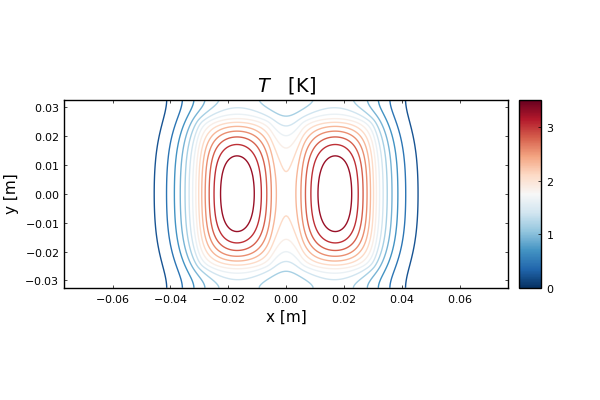

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [13]:
plot(Tn,sys.grid,legend=true,color=cgrad(:RdBu,rev=true),line_z=0,xlabel="x [m]",ylabel="y [m]",title=L"T \quad [\mathrm{K}]")

### Plot the temperature along the OHP channel

In [14]:
# plot(sys.qline[1].arccoord,temperature_linesource(integrator),xlabel=L"\xi",ylabel=L"T - T_0")

# OHP inner part

In [15]:
nondi_Q_to_Q = 1.35E+02
t_to_nondi_t = 2.83E-01
function di_T_to_nondi_T(di_T;T0=295.0) 
    
    (di_T+T0)/T0
    
end



di_T_to_nondi_T (generic function with 1 method)

In [586]:
    ω = sqrt(2.45E+03);
    ℘L = 2.05E+05;
    k = 0.106024683

    θinitial=1.0
    θc = 1.0; # useless

    Hwc = 0.0; #not useful later on. H between wall and condenser, 
#     Hₗ   =  1600.0; # liquid wall heat transfer coeffcient
    Hₗ   =  1.01E+03; # liquid wall heat transfer coeffcient for static fluids
    Hδ  = 4.65E+02;


In [600]:
    d = 6.56e-3 # dimensionless diameter
    L = 34.35  # total length of the pipe when streched to a 1D pipe
    L2D = 1.0 # the actual length of the bended pipe in the real world
    angle = 0*pi/2 # inclination angle 
    ΔTthres = 0.3/295.0 *0.1; # use a small threshold
    closedornot = true

true

In [601]:
    nucleatenum = 256
    Xstations = sort(rand(nucleatenum).*L);
#     Xstations = LinRange(0.0,L-L/nucleatenum,nucleatenum)
#     boilingΔt = 0.05

In [602]:
tube = Tube(d,L,L2D,angle,ΔTthres,closedornot);

In [603]:
# useless
Xe = map(tuple, [1.0], [3.0])
We = [0.0]
evap = Evaporator(Xe,We);

In [611]:
# useless
Xc = map(tuple, [0.0,3.0], [1.0,4.0])
cond = Condenser(θc,Xc,Hwc);

In [621]:
X0,realratio = randomXp(L,numofslugs=60,chargeratio=0.45)

dXdt0_l = zeros(length(X0))
dXdt0_r = zeros(length(X0))
dXdt0 = map(tuple,dXdt0_l,dXdt0_r)


realratio

0.4369924876228458

In [622]:
N=numpts(ohp)

ρ = 102.593344 # density ratio
Xarrays,θarrays = constructXarrays(X0,N,θinitial,L)
liquids=Liquid(Hₗ,ρ,ω,℘L,X0,dXdt0,Xarrays,θarrays);

In [623]:
# P = [1.0,1.0,1.0,1.0,1.0]; # closed end

γ = 1.4;
# Hδ = 4.64E+02
P = 0*zeros(length(X0)) .+ 1.0;
δ = 0*zeros(length(X0)) .+ 2.78E-02;
# δ = 0*zeros(length(X0)) .+ 2.78E-02 .* 10; # use a random film thickness
vapors=Vapor(γ,Hδ,P,δ);

In [624]:
α = 1.154e-5 # nondimensional thermal diffusivity = (αₐ d^2) / (νₗ height^2)
# Xwallarray,θwallarray = constructXarrays(L,N,θinitial)
Xwallarray,θwallarray = constructXarrays(sys.qline[1].arccoord,L,θinitial)
θwallarray = di_T_to_nondi_T(temperature_linesource(integrator));

wall = Wall(α,Δt,Xstations,Xwallarray,θwallarray);

In [625]:
sys0_nomapping = PHPSystem_nomapping(tube,evap,cond,liquids,vapors,wall);
θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall = sys_interpolation(sys0_nomapping)
mapping = Mapping(θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall);

In [626]:
sys0 = PHPSystem(tube,evap,cond,liquids,vapors,wall,mapping);

### construct state vector U

In [627]:
Lvaporplug = XptoLvaporplug(X0,sys0.tube.L,sys0.tube.closedornot)
M = nondi_PtoD(P) .* Lvaporplug
# M = P.^(1/γ).* Lvaporplug


u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];

In [628]:
cb_boiling =  DiscreteCallback(boiling_condition,boiling_affect!)
# cb_boiling =  PeriodicCallback(boiling_affect!,0.01*t_to_nondi_t)
cb_merging =  DiscreteCallback(merging_condition,merging_affect!)

cbst = CallbackSet(cb_boiling,cb_merging);

# combine inner tube and plate together

In [646]:
tspan = (0.0, 300.0);
dt_record = tspan[2] /200;

tstep=1e-3

N_iter = 1
# tstep_plate = tstep/N_iter
# dt_record = tstep

1

In [647]:
u0 = newstate(sys)
integrator_plate = init(u0,tspan,sys)
Tplate = temperature(integrator_plate);

In [648]:
p = sys0
u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];
prob = ODEProblem(ODE_innertube, u, tspan, p)
integrator_tube = init(prob, RK4(),save_everystep=false, dt=tstep*t_to_nondi_t, callback=cbst);

In [649]:
plate_hist = []
tube_hist  = []

currentsys = integrator_tube.p
currentsys = getcurrentsys(integrator_tube.u,currentsys);

In [650]:
# integrator_plate = plate_hist[end-3]
# integrator_tube = tube_hist[end-3]

# currentsys = integrator_tube.p
# currentsys = getcurrentsys(integrator_tube.u,currentsys);

# tspan = (integrator_plate.t, integrator_plate.t + 1.0);
# dt_record = 0.01

In [651]:
# tspan = (integrator_plate.t, integrator_plate.t + 0.2);
# dt_record = tstep

In [652]:

@time for t in tspan[1]:tstep:tspan[2]
    

#   for j in 1:N_iter
        currentsys.wall.θarray = di_T_to_nondi_T(temperature_linesource(integrator_plate))
        currentsys = getcurrentsys(integrator_tube.u,currentsys)


        nondi_qtmp = sys_to_heatflux(currentsys)
        qtmp = nondi_Q_to_Q*nondi_qtmp
        set_linesource_strength!(sys,qtmp)


        Tplate = ADI_timemarching!(Tplate,sys,tstep)
#     end
    integrator_plate.t += tstep
    
    # reinitialize the integrator_tube to avoid some mysterious problems
    prob = ODEProblem(ODE_innertube, deepcopy(integrator_tube.u), (integrator_plate.t*t_to_nondi_t-tstep*t_to_nondi_t,integrator_plate.t*t_to_nondi_t), currentsys)
    integrator_tube = init(prob, RK4(), callback=cbst, dt=tstep*t_to_nondi_t);
    step!(integrator_tube);
#     @time step!(integrator_tube, tstep*t_to_nondi_t)

    if (mod(integrator_plate.t,dt_record) < 1e-6) || (mod(-integrator_plate.t,dt_record) < 1e-6)
        push!(plate_hist,deepcopy(integrator_plate)); 
        push!(tube_hist,deepcopy(integrator_tube));
        println(integrator_plate.t)
    end
    
end

Boiled! at 33.622884968008506on 0.02830000000000002
1.4999999999999456
Boiled! at 1.692416005681602on 0.565999999999969
2.9999999999997806
4.4999999999998375
Boiled! at 1.464486373288532on 1.4150000000000011
6.000000000000338
7.500000000000839
9.000000000000451
10.49999999999962
11.999999999998789
13.499999999997957
merged!
14.999999999997126
Boiled! at 1.692416005681602on 4.301599999999155
Boiled! at 33.622884968008506on 4.301599999999155
16.499999999997183
17.999999999999016
19.50000000000085
21.000000000002682
22.500000000004515
merged!
24.00000000000635
merged!
Boiled! at 14.402790775405235on 6.933500000001969
Boiled! at 15.589682630290921on 6.933500000001969
25.500000000008182
27.000000000010015
merged!
28.50000000001185
30.00000000001368
merged!
Boiled! at 14.402790775405235on 8.886200000004354
31.500000000015515
33.00000000001379
34.500000000010296
36.0000000000068
merged!
merged!
merged!
37.500000000003304
38.99999999999981
merged!
40.49999999999631
merged!
41.999999999992816
4

In [653]:
        push!(plate_hist,deepcopy(integrator_plate)); 
        push!(tube_hist,deepcopy(integrator_tube));
        println(integrator_plate.t)

300.0009999998178


In [654]:
sysfinal = []
for i = 1:length(tube_hist)
    push!(sysfinal, deepcopy(getcurrentsys(tube_hist[i].u,tube_hist[i].p)))
end

In [655]:
# plot(ohp,fillalpha=0,line_z=temperature_linesource(integrator_plate))

In [656]:
maximum(temperature(plate_hist[end-5])[:])

5.176681493201488

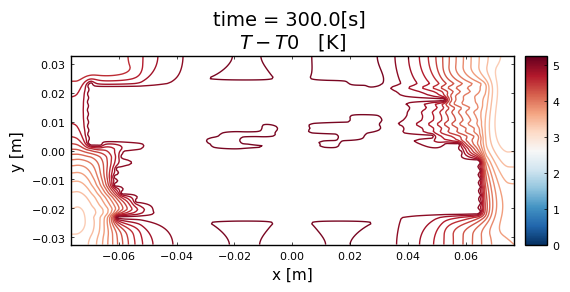

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
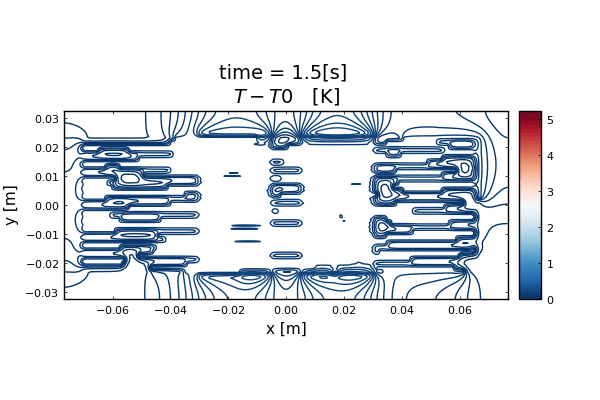

In [657]:
Tmax = maximum(temperature(plate_hist[end-1])[:])
Tmin = 0.0
@gif for i = 1:1:length(plate_hist)
# @gif     for i = 1:1:1  
    
plot(temperature(plate_hist[i]),sys.grid,legend=true,color=cgrad(:RdBu,rev=true),clim=(Tmin,Tmax),line_z=0,xlabel="x [m]",ylabel="y [m]",title=string("time = ", round(plate_hist[i].t, digits=2), "[s] \n",  L"T - T0 \quad [\mathrm{K}]"))
end

In [641]:
minimum(temperature(plate_hist[end]))

0.005988178601535998

In [642]:
length(plate_hist)

2

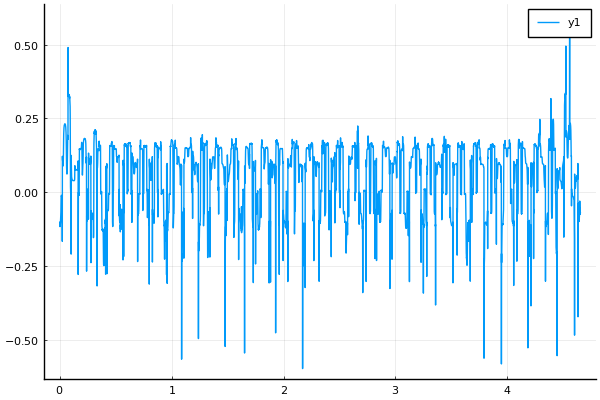

In [643]:
plot(sys.qline[1].arccoord,sys_to_heatflux(sysfinal[end]))

In [644]:
@gif for i=1:1:1
    Htmp = sys_to_Harray(sysfinal[i])
    plot(ohp,fillalpha=0,linecolor=cgrad([:gold, :blue],rev=true),line_z=Htmp,xlabel="x ",ylabel="y ",border=:none,axis=nothing)
end

LoadError: [91mInterruptException:[39m

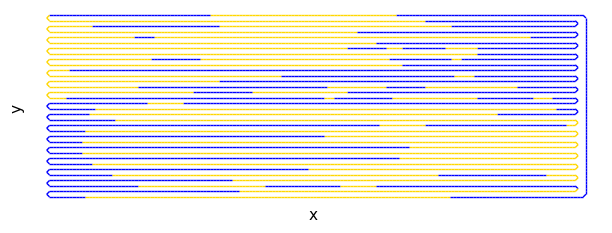

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
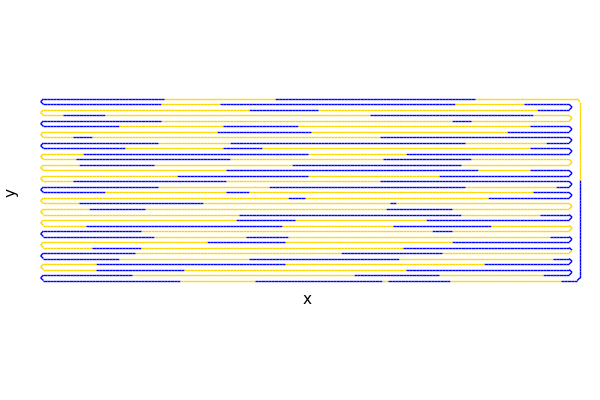

In [660]:
@gif for i=1:10:length(sysfinal)
    Htmp = sys_to_Harray(sysfinal[i])
    plot(ohp,fillalpha=0,linecolor=cgrad([:gold, :blue],rev=true),line_z=Htmp,xlabel="x ",ylabel="y ",border=:none,axis=nothing)
end

# plot the OHP

In [ ]:
plot(sysfinal[60],xlim=(19.0,20.0),ylim=(295.0,298.0))

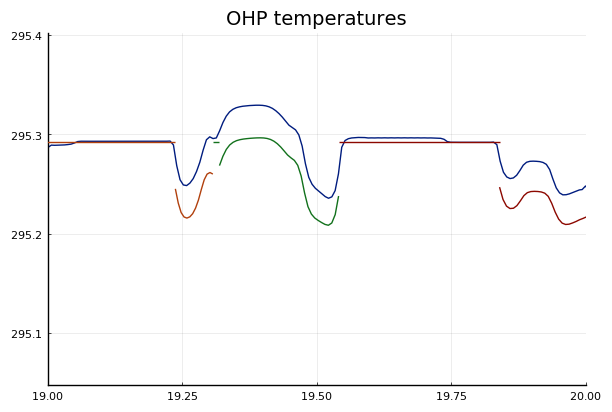

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\ComputationalHeatTransfer.jl\src\tmp.gif
└ @ Plots C:\Users\liyux\.julia\packages\Plots\FKcum\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\ComputationalHeatTransfer.jl\\src\\tmp.gif")
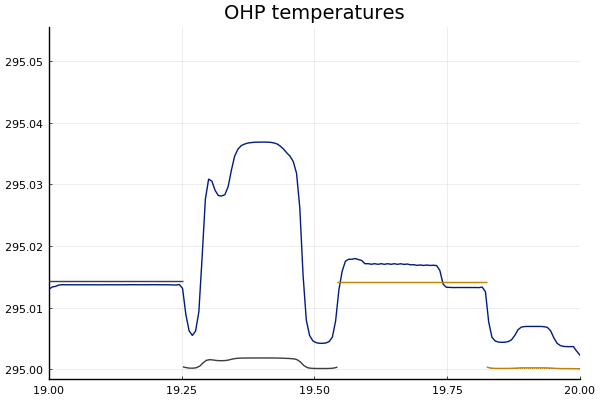

In [597]:
@gif for ii=1:length(sysfinal)
     plot(sysfinal[ii],plottype="T",xlim=(19.0,20.0))
end

In [ ]:
sysfinal[end].mapping.H_interp_liquidtowall[8.5:0.01:8.7]

In [ ]:
plot(sysfinal[end-30],plottype="T",xlim=(8.0,9.0))

In [ ]:
plot(sysfinal[end-3],plottype="T",xlim=(8.0,9.0))

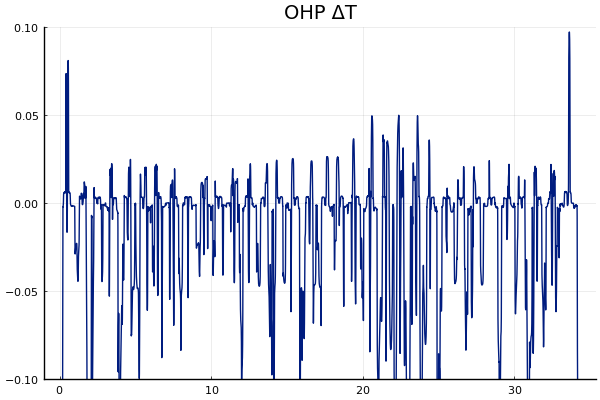

In [599]:
plot(sysfinal[end],plottype="ΔT",ylim=(-0.1,0.1))

In [ ]:
@gif for ii=1:length(sysfinal)
    plot(sysfinal[ii],plottype="ΔT")
end

In [ ]:
# plate_hist, integrator_plate = load("plate_OHP_boiling.jld2", "plate_hist",  "integrator_plate")

In [ ]:
# tube_hist, integrator_tube = load("tube_OHP_boiling.jld2", "tube_hist",  "integrator_tube")

In [ ]:
sysfinal

In [658]:
save("plate_OHP.jld2", "plate_hist", plate_hist, "integrator_plate", integrator_plate)

In [659]:
save("tube_OHP.jld2", "tube_hist", tube_hist, "integrator_tube",integrator_tube)

In [661]:
inch = 2.54e-2;

# x = [-2.7inch,0.0,2.7inch];
# y = [0.0,0.0,0.0];

x = [0.0]
y = [0.0]

X =  VectorData(x,y);

In [662]:
H = Regularize(X,cellsize(sys),I0=origin(sys.grid))
g = ScalarData(X);

In [663]:
ghist = []
thist = []
for i = 1:length(plate_hist)
    H(g,temperature(plate_hist[i]))
    append!(ghist,deepcopy(g))
    append!(thist,plate_hist[i].t)
end

In [664]:
RTDx,RTDy = load("RTD4.jld2","RTDx","RTDy")

([10.89866157, 14.34034417, 21.22370937, 37.8585086, 64.24474187, 96.36711281, 125.6214149, 152.581262, 182.4091778, 211.0898662, 247.2275335, 275.334608], [16.58279415, 20.15358253, 23.16569499, 25.33894001, 26.617514, 27.22537814, 27.38734721, 27.60554664, 27.82321258, 27.81787763, 28.03436988, 27.97333806])

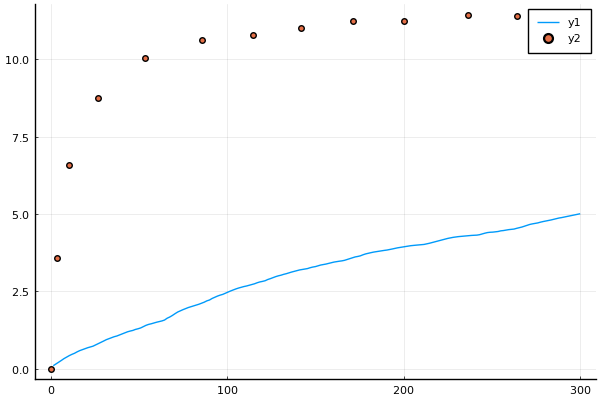

In [665]:
plot(thist,ghist)
scatter!(RTDx .- RTDx[1],RTDy .- RTDy[1])

In [232]:
rand(10)

10-element Array{Float64,1}:
 0.8021563568981787
 0.5700605586743968
 0.9934740554481349
 0.8576192631840909
 0.8860417788221286
 0.8135222052599895
 0.29068730072130666
 0.511233266339086
 0.6765976609043118
 0.7437110456364755